In [1]:
import os
os.chdir('/content/drive/MyDrive/fraud_detection')

import kaggle_dataset_downloader, data_setup, model_builder, engine, utils
import pandas as pd
import torch
from torch import nn

# Print PyTorch version
print(f"PyTorch version: {torch.__version__}")
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Working on: {device}")

PyTorch version: 2.0.1+cu118
Working on: cuda


# 1. Data setup

## 1.1 Download and analyze data

Steps include:
- Downloading the credit card fraud detection dataset from Kaggle through **download_data** method from the **kaggle_dataset_downloader.py** file.

- Analyzing the data using helper functions from the file **utils.py**.


In [2]:
# Dataset name
DATASET = "mlg-ulb/creditcardfraud"

# Path to download the data
DOWNLOAD_PATH = "/content/drive/MyDrive/fraud_detection/data"

# Download dataset to the download path
kaggle_dataset_downloader.download_data(dataset=DATASET,
                                        download_path=DOWNLOAD_PATH)

Data already exists in the specified directory: /content/drive/MyDrive/fraud_detection/data


In [3]:
# Add name of the csv file to the path
DATA_PATH = DOWNLOAD_PATH + "/creditcard.csv"

# Read data
df = pd.read_csv(DATA_PATH)

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


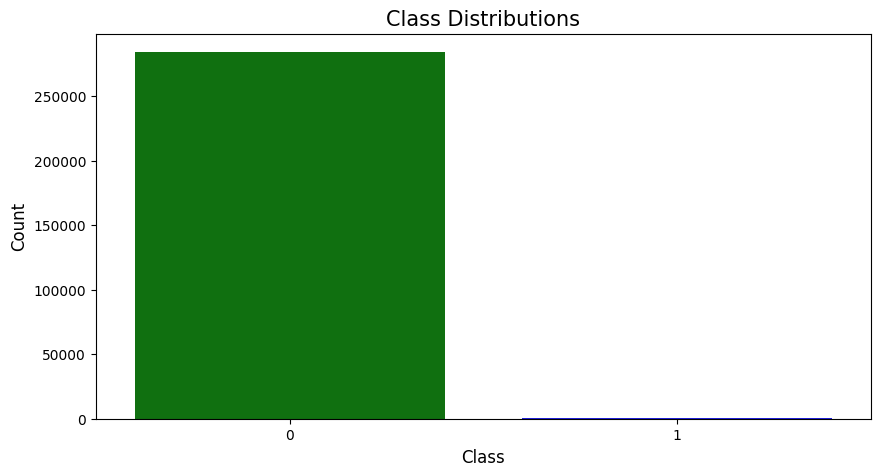

In [6]:
utils.visualize_class_distributions(data_frame=df,
                              class_column="Class")

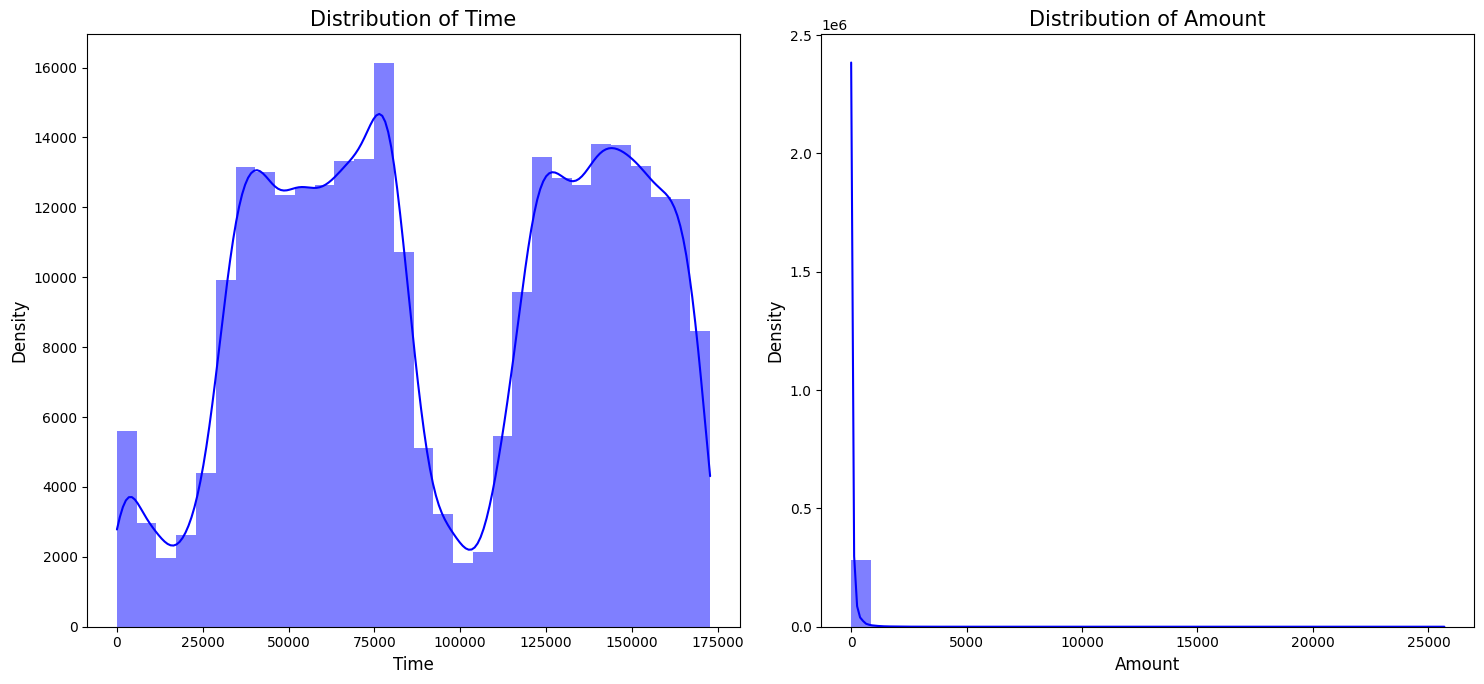

In [7]:
features = ["Time", "Amount"]
utils.visualize_feature_distributions(data_frame=df,
                                features=features)

In [8]:
# Scale "Amount" and "Time" (others are already scaled)
from sklearn.preprocessing import RobustScaler

# RobustScaler is less prone to outliers.

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [9]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


## 1.2 Data into Dataloaders

Steps include:
- Having the training dataloader and test dataloader using **create_dataloaders** method from the **data_setup.py** file.


In [10]:
X = df.drop("Class", axis=1)
y = df["Class"]

len(X), len(y)

(284807, 284807)

In [11]:
train_loader, test_loader = data_setup.create_dataloaders(X=X,
                                                          y=y,
                                                          batch_size=32,
                                                          dtype=torch.float32,
                                                          sampling="undersampling",
                                                          test_size=0.2)

Undersampling applied
New class counts: Counter({0: 492, 1: 492})
Shape of X_train: (787, 30) | Length of X_train: 787
Shape of y_train: (787,) | Length of y_train: 787
Shape of X_test: (197, 30) | Length of X_test: 197
Shape of y_test: (197,) | Length of y_test: 197


# 2. Initializing, training and evaluating the model

## 2.1 Build the model

Steps include:
- Initialize the **FraudDetectionModel** network specified in the **model_builder.py** file. Network architecture can be seen there.

- Define the loss function and optimizer.

- Train the network using **train** function defined in **engine.py**

- Visualize the results using **visualize_results** method from **utils.py**

In [12]:
model_0 = model_builder.FraudDetectionModel(input_shape=30,
                                            output_shape=1,
                                            hidden_units=64).to(device)
model_0

FraudDetectionModel(
  (net): Sequential(
    (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=30, out_features=64, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): ReLU()
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=64, out_features=1, bias=True)
  )
)

## 2.2 Loss function, optimizer, learning rate scheduler

In [13]:
# Define the loss function
loss_fn = nn.BCEWithLogitsLoss()
# Define the optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,
                               step_size=7,
                               gamma=0.1)

## 2.3 Training the network

In [14]:
# Number of epochs
EPOCHS = 10

# Training
results = engine.train(model=model_0,
                     train_dataloader=train_loader,
                     test_dataloader=test_loader,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=EPOCHS,
                     device=device,
                       scheduler=scheduler)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5220 | train_acc: 0.7583 | test_loss: 0.4116 | test_acc: 0.8661
Epoch: 2 | train_loss: 0.3073 | train_acc: 0.8899 | test_loss: 0.2673 | test_acc: 0.8973
Epoch: 3 | train_loss: 0.2530 | train_acc: 0.9079 | test_loss: 0.1968 | test_acc: 0.9241
Epoch: 4 | train_loss: 0.1978 | train_acc: 0.9341 | test_loss: 0.1821 | test_acc: 0.9420
Epoch: 5 | train_loss: 0.1936 | train_acc: 0.9263 | test_loss: 0.1705 | test_acc: 0.9464
Epoch: 6 | train_loss: 0.1876 | train_acc: 0.9333 | test_loss: 0.1824 | test_acc: 0.9375
Epoch: 7 | train_loss: 0.1730 | train_acc: 0.9383 | test_loss: 0.1762 | test_acc: 0.9464
Epoch: 8 | train_loss: 0.1606 | train_acc: 0.9454 | test_loss: 0.1759 | test_acc: 0.9420
Epoch: 9 | train_loss: 0.1622 | train_acc: 0.9458 | test_loss: 0.1719 | test_acc: 0.9464
Epoch: 10 | train_loss: 0.1717 | train_acc: 0.9395 | test_loss: 0.1705 | test_acc: 0.9420


## 2.4 Visualizing results

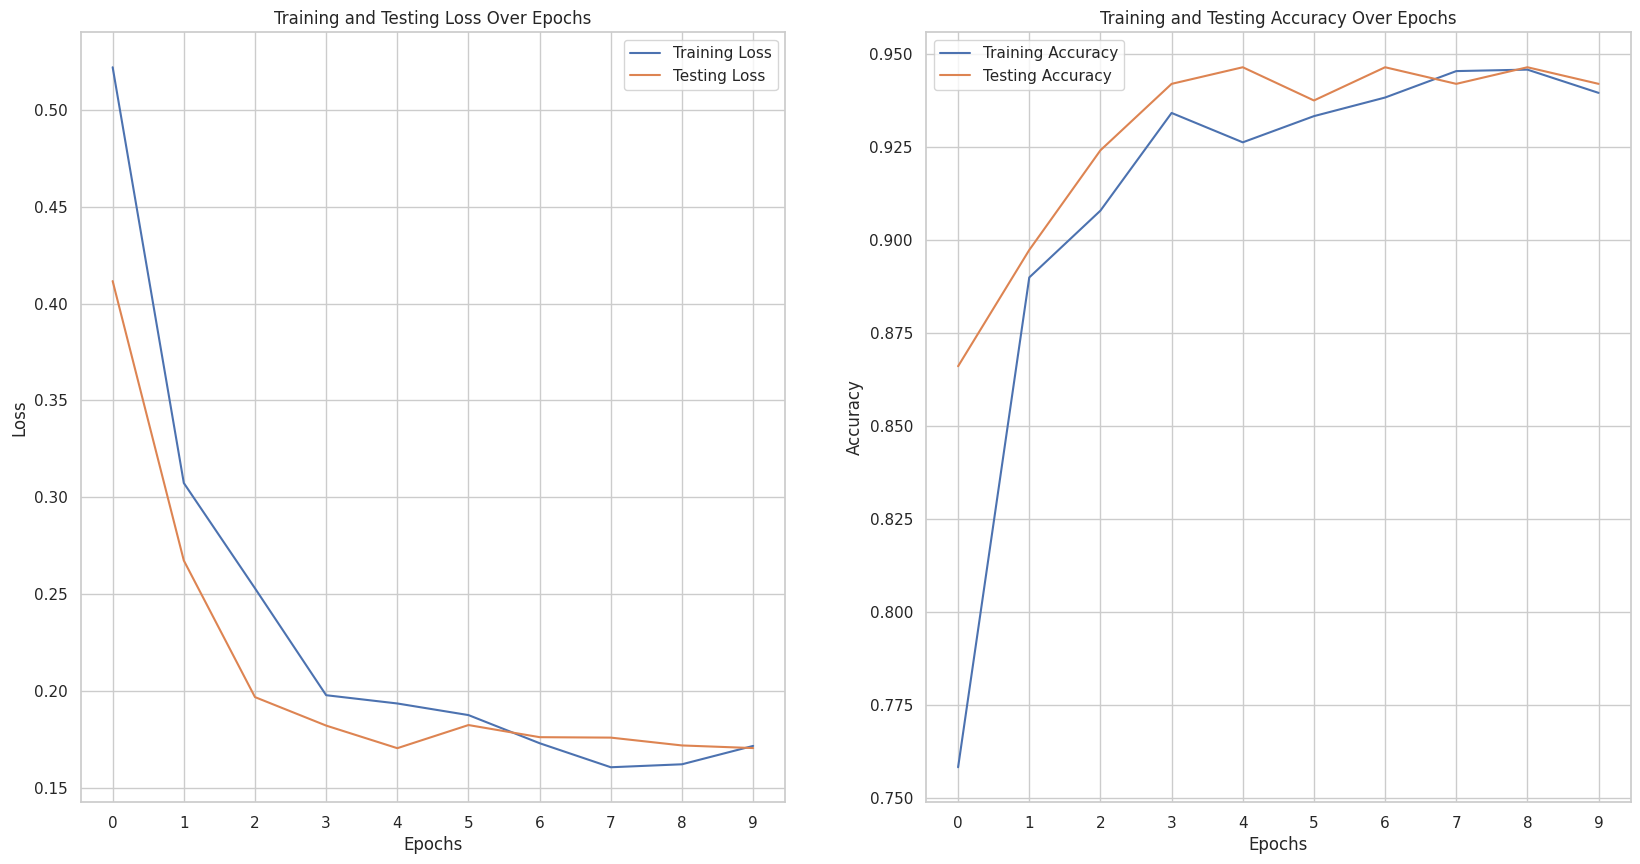

In [15]:
utils.visualize_results(results)